In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
db = load_db()

Using Theano backend.


In [6]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
        
    for k, v in j['stats'].items():
        col[k] = v

    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')

## Fix stride. vary nb of layers

In [3]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==4]
df = df.sort_values(by='nb_layers')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37237f9fff4f7b31450f75523b320087,128.0,1.573323e-01,0.842668,10.071477,0.068,7.880537e-01,2.310270e-01,6.505211e+07,0.054,0.002090,0.768973,3.756295,0.008,0.008,0.771,0.392858,0.100,0.607142,4.454555,5.147774e-01,0.108975,12.480100,0.863,7.949966e-01,0.426790,1.428098e+08,0.429,0.002096,0.573210,4.121679,1,6529.0,NaN,0.069,mnist_deep,4.0,NaN
c9508eab5a4e53ba9e7908753321126b,128.0,5.361965e-02,0.946380,17.601500,0.512,9.264345e-01,1.090867e-01,6.490299e+07,0.453,0.002002,0.890913,6.613565,0.058,0.053,0.513,0.292081,0.112,0.707919,9.658321,7.337083e-01,0.111441,40.973095,0.416,9.216716e-01,0.167718,1.427012e+08,0.329,0.002008,0.832282,11.915987,2,825985.0,NaN,0.072,mnist_deep,4.0,NaN
60168f92bfbc6331027b213e2e9d4f6f,128.0,3.497587e-02,0.965024,13.157985,0.771,9.371452e-01,8.308562e-02,6.482572e+07,0.694,0.002000,0.916914,7.141914,0.122,0.109,0.453,0.245890,0.142,0.754110,10.135502,7.578208e-01,0.114442,47.322350,0.179,8.776129e-01,0.115620,1.426912e+08,0.157,0.002006,0.884380,12.196813,3,1645441.0,NaN,0.050,mnist_deep,4.0,NaN
2f1da78673f5e27e2fc5aafcd9bb7baf,128.0,2.781215e-02,0.972188,10.966901,0.821,8.986741e-01,7.306449e-02,6.484647e+07,0.758,0.002000,0.926936,6.735068,0.164,0.148,0.380,0.222300,0.162,0.777700,9.550841,6.756181e-01,0.126203,28.586235,0.139,7.451142e-01,0.095533,1.427408e+08,0.120,0.002006,0.904467,8.559813,4,2464897.0,NaN,0.040,mnist_deep,4.0,NaN
9a6da4b02514b0828331badb37217bb7,128.0,1.845246e-02,0.981548,7.802787,0.975,8.961346e-01,6.123510e-02,6.489214e+07,0.901,0.002769,0.938765,6.751542,0.203,0.188,0.208,0.195527,0.105,0.804473,8.341701,6.084109e-01,0.135215,18.995279,0.011,6.927141e-01,0.073663,1.428236e+08,0.010,0.002775,0.926337,7.843813,5,3284353.0,NaN,0.014,mnist_deep,4.0,NaN
78d155d20b40759f2f5ac333aee1c616,128.0,9.186998e-17,1.000000,1.000000,1.000,-4.342945e-11,2.046555e-10,6.521397e+07,1.000,0.512558,1.000000,1.000000,0.000,0.000,0.000,0.187838,0.000,0.812162,1.003024,-1.712995e-11,0.162200,1.080352,0.000,-3.069277e-11,0.005880,1.431011e+08,0.000,0.512564,0.994120,1.001360,6,4103809.0,NaN,0.000,mnist_deep,4.0,NaN


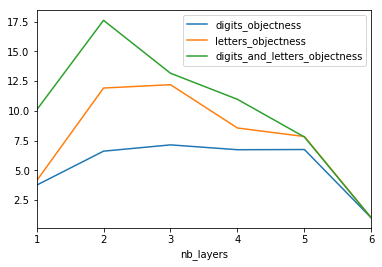

In [5]:
df.plot("nb_layers", ["digits_objectness", "letters_objectness", "digits_and_letters_objectness"])

In [ ]:
df.plot("nb_layers", ["digits_diversity", "letters_diversity"])

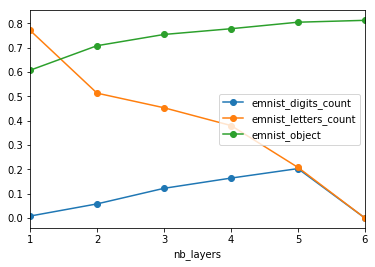

In [14]:
df.plot("nb_layers", ["emnist_digits_count", "emnist_letters_count", "emnist_object"], style='o-')

In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    fig = plt.figure()
    plt.imshow(X)
    plt.show()

## Fix nb layers. Vary stride

In [19]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise_count,sampler,stride
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5511413bb44248b61f32518f638a8d9e,0.043103,0.956897,15.068205,0.712,0.912121,0.109552,6.482374e+07,0.621,0.002,0.890448,6.414445,0.031,0.029,0.694,0.310742,0.131,0.689258,8.729666,0.646863,0.100108,26.331829,0.231,0.917145,0.121261,1.426300e+08,0.193,0.002006,0.878739,13.536750,3,1645441.0,0.057,mnist_deep,0.0
f316dedd30ebc5f51c4678f07979436c,0.031410,0.968590,14.714568,0.773,0.924139,0.083757,6.478472e+07,0.713,0.002,0.916243,6.948976,0.081,0.073,0.572,0.254680,0.178,0.745320,12.290185,0.775435,0.104893,55.180447,0.172,0.926554,0.101766,1.426092e+08,0.153,0.002006,0.898234,14.877086,3,1645441.0,0.055,mnist_deep,1.0
901dad8ec11f23191d86fa6279d47c65,0.031575,0.968425,15.541529,0.707,0.915356,0.084485,6.481787e+07,0.656,0.002,0.915515,6.845440,0.108,0.096,0.482,0.246643,0.154,0.753357,12.352144,0.765771,0.100727,52.514980,0.250,0.927061,0.110468,1.426481e+08,0.213,0.002006,0.889532,14.415942,3,1645441.0,0.043,mnist_deep,2.0
60168f92bfbc6331027b213e2e9d4f6f,0.034976,0.965024,13.157985,0.771,0.937145,0.083086,6.482572e+07,0.694,0.002,0.916914,7.141914,0.122,0.109,0.453,0.245890,0.142,0.754110,10.135502,0.757821,0.114442,47.322350,0.179,0.877613,0.115620,1.426912e+08,0.157,0.002006,0.884380,12.196813,3,1645441.0,0.050,mnist_deep,4.0


In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    fig = plt.figure()
    plt.imshow(X)
    plt.show()

# wta lifetime sparsity

In [22]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5df44b4a1f76008eafba6e9b566478c6,0.522662,0.477338,3.300958,0.042,4.883483e-01,0.377219,6.508613e+07,0.038,0.328624,0.622781,2.131843,0.011,0.010,0.336,0.628205,0.066,0.371795,2.446524,3.160054e-01,0.588261,4.250678,0.938,5.265812e-01,0.683533,1.428550e+08,0.233,0.328630,0.316467,2.126026,1,6529.0,0.020,mnist_deep_lifetime,NaN,0.7
23d22605e16298e02bf390236e483914,0.233133,0.766867,11.505471,0.285,7.997974e-01,0.239657,6.488142e+07,0.250,0.090506,0.760343,4.112755,0.058,0.051,0.406,0.279916,0.110,0.720084,8.497730,6.513849e-01,0.183228,26.278839,0.676,7.665223e-01,0.320328,1.426311e+08,0.332,0.090512,0.679672,7.157652,2,825985.0,0.039,mnist_deep_lifetime,NaN,0.7
22f21be8ae12aba3457e2469d290dd52,0.639410,0.360590,0.999999,0.000,-4.342945e-11,0.397720,NaN,0.000,1.001000,0.602280,0.999993,0.000,0.000,0.000,0.883035,0.000,0.116965,1.000001,-1.712995e-11,0.859961,0.999999,0.000,-3.069277e-11,0.805414,NaN,0.000,1.001006,0.194586,1.000004,3,1645441.0,1.000,mnist_deep_lifetime,NaN,0.7
cf34fddfc38e4eed28e73fcffa2f7066,0.034312,0.965688,13.207333,0.846,9.613887e-01,0.074755,6.479994e+07,0.769,0.002006,0.925245,7.707634,0.102,0.084,0.456,0.275638,0.130,0.724362,12.693130,7.584960e-01,0.132599,42.675426,0.098,9.324401e-01,0.102940,1.426632e+08,0.087,0.002012,0.897060,14.936293,4,2464897.0,0.056,mnist_deep_lifetime,NaN,0.7
5c5bf9994c2b1ba4d86540bb8f9c3091,0.024189,0.975811,11.187900,0.909,9.681023e-01,0.073043,6.480941e+07,0.844,0.002000,0.926957,7.829299,0.119,0.105,0.469,0.271232,0.140,0.728768,11.279076,7.360543e-01,0.124638,39.702442,0.067,8.687896e-01,0.105799,1.426949e+08,0.060,0.002006,0.894201,12.161733,5,3284353.0,0.024,mnist_deep_lifetime,NaN,0.7
f7a80edd7d1c9c90515651e3e86798d4,0.023830,0.976170,10.132069,0.928,9.539540e-01,0.063367,6.480640e+07,0.852,0.002000,0.936633,7.822666,0.141,0.130,0.415,0.264687,0.134,0.735313,11.650751,7.187109e-01,0.137298,34.465794,0.038,8.751838e-01,0.103406,1.427050e+08,0.035,0.002006,0.896594,12.472565,6,4103809.0,0.034,mnist_deep_lifetime,NaN,0.7


In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    fig = plt.figure()
    plt.imshow(X)
    plt.show()

## wta kchannel

In [23]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
86edda1cd4ca18d86af1d30a3691743c,0.080477,0.919523,17.730999,0.155,0.831264,0.163009,6.493536e+07,0.133,0.002000,0.836991,4.641634,0.031,0.030,0.761,0.286676,0.197,0.713324,6.872862,0.595692,0.084899,21.616522,0.751,0.874809,0.216747,1.426393e+08,0.559,0.002006,0.783253,8.915785,1,6529.0,0.094,mnist_deep_kchannel,NaN,0.9
e2a3cf325e945c1a0be38073933f5938,0.051193,0.948807,20.280416,0.509,0.922437,0.105584,6.486263e+07,0.438,0.002000,0.894416,6.592316,0.082,0.074,0.580,0.259248,0.167,0.740752,11.651826,0.780166,0.112815,52.920902,0.426,0.935885,0.134873,1.426424e+08,0.347,0.002006,0.865127,13.841786,2,825985.0,0.065,mnist_deep_kchannel,NaN,0.9
876bbdc0501b9e043d5e566bc13f6a5a,0.036674,0.963326,14.189510,0.693,0.921693,0.077887,6.480994e+07,0.636,0.002000,0.922113,7.004585,0.125,0.113,0.425,0.238127,0.164,0.761873,11.007601,0.729812,0.097576,43.878284,0.251,0.890408,0.114385,1.426517e+08,0.211,0.002006,0.885615,12.584548,3,1645441.0,0.056,mnist_deep_kchannel,NaN,0.9
e72e79bf4cd53875e7ec8784a64b45ce,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.736383,0.112633,42.219612,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,0.046,mnist_deep_kchannel,NaN,0.9
40b4aa2f3f994823faf01e804567b430,0.027230,0.972770,10.462719,0.878,0.912284,0.068199,6.482983e+07,0.803,0.002004,0.931801,7.043870,0.136,0.126,0.414,0.242237,0.135,0.757763,10.329323,0.701115,0.124744,32.360668,0.090,0.817857,0.097824,1.427340e+08,0.079,0.002010,0.902176,10.536287,5,3284353.0,0.032,mnist_deep_kchannel,NaN,0.9
bb8051dece1c1d1c64b96ec2a6e53179,0.015016,0.984984,6.574772,0.945,0.741461,0.036610,6.492172e+07,0.904,0.007648,0.963390,5.054827,0.214,0.209,0.544,0.152843,0.311,0.847157,9.197904,0.635446,0.132672,23.531170,0.033,0.675831,0.073278,1.428226e+08,0.033,0.007654,0.926722,7.549600,6,4103809.0,0.022,mnist_deep_kchannel,NaN,0.9


In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:64]
    X = grid_of_images_default(X)
    fig = plt.figure()
    plt.imshow(X)
    plt.show()

In [24]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
414122cb7ccc4a125385d75e5c0eb585,0.034061,0.965939,12.497256,0.804,0.923587,0.097247,6.480683e+07,0.723,0.002000,0.902753,6.797603,0.076,0.065,0.571,0.273740,0.163,0.726260,10.970304,0.770649,0.105082,53.092396,0.153,0.854546,0.096067,1.426501e+08,0.128,0.002006,0.903933,11.954018,4,2464897.0,0.043,mnist_deep_kchannel,NaN,0.7
e72e79bf4cd53875e7ec8784a64b45ce,0.035782,0.964218,13.253835,0.797,0.962560,0.097950,6.485025e+07,0.715,0.002012,0.902050,7.298103,0.097,0.091,0.501,0.271282,0.128,0.728718,11.336662,0.736383,0.112633,42.219612,0.157,0.860804,0.093629,1.427092e+08,0.136,0.002018,0.906371,12.298592,4,2464897.0,0.046,mnist_deep_kchannel,NaN,0.9


In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:64]
    X = grid_of_images_default(X)
    fig = plt.figure()
    plt.imshow(X)
    plt.show()

In [26]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==4]
df = df.sort_values(by='bottleneck')
df

,bottleneck,digits_and_letters_entropy,digits_and_letters_object,digits_and_letters_objectness,digits_count,digits_diversity,digits_entropy,digits_frechet,digits_max,digits_mmd,digits_object,digits_objectness,emnist_digits_count,emnist_digits_max,emnist_letters_count,emnist_letters_entropy,emnist_letters_max,emnist_object,emnist_objectness,hwrt_diversity,hwrt_entropy,hwrt_objectness,letters_count,letters_diversity,letters_entropy,letters_frechet,letters_max,letters_mmd,letters_object,letters_objectness,nb_layers,nb_params,noise_count,sampler,stride,zero_ratio
job_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02d9a28990d5450c43aba831b076a183,2.0,0.063391,0.936609,3.301756,0.929,0.575215,0.083164,6.508503e+07,0.840,0.125149,0.916836,3.276995,0.571,0.553,0.066,0.253365,0.000,0.746635,3.291194,0.317298,0.370513,3.364964,0.000,0.542095,0.211561,1.429900e+08,0.000,0.125155,0.788439,3.793707,4,1658371.0,0.071,mnist_capacity,NaN,NaN
ee489161b68ba065d2c8a6521c2ffd80,4.0,0.126768,0.873232,3.554765,0.617,0.630935,0.195478,6.515182e+07,0.402,0.107870,0.804522,3.126094,0.003,0.003,0.263,0.298916,0.000,0.701084,3.354379,0.396231,0.220163,5.858049,0.042,0.580248,0.282490,1.430165e+08,0.042,0.107876,0.717510,4.066348,4,1671173.0,0.341,mnist_capacity,NaN,NaN
e75af357b895ac3f0cbf19fa2c64729b,8.0,0.026625,0.973375,10.911726,0.876,0.921899,0.061368,6.489080e+07,0.813,0.002046,0.938632,7.286762,0.140,0.134,0.336,0.250645,0.125,0.749355,10.873708,0.660309,0.144526,24.507387,0.086,0.841912,0.094856,1.427832e+08,0.077,0.002052,0.905144,11.550976,4,1696777.0,0.038,mnist_capacity,NaN,NaN
cd3d3b694a2fdf5938103feb39534e7d,16.0,0.023931,0.976069,10.510137,0.890,0.939420,0.070366,6.480083e+07,0.814,0.002000,0.929634,7.456376,0.128,0.115,0.438,0.236221,0.158,0.763779,11.863833,0.740309,0.105063,44.320431,0.089,0.821300,0.084330,1.426907e+08,0.080,0.002006,0.915670,11.239218,4,1747985.0,0.021,mnist_capacity,NaN,NaN
7e7214d68f06924b5f39b0901b6a78bb,32.0,0.035119,0.964881,13.497774,0.786,0.927219,0.081446,6.480464e+07,0.699,0.002000,0.918554,7.029863,0.095,0.085,0.573,0.241942,0.179,0.758058,11.828557,0.761347,0.110597,49.484310,0.162,0.895567,0.093350,1.426463e+08,0.139,0.002006,0.906650,13.606885,4,1850401.0,0.052,mnist_capacity,NaN,NaN
fcfe73728bc4338ad48a0487eca9bd9c,64.0,0.029763,0.970237,11.506212,0.884,0.955944,0.089132,6.479563e+07,0.780,0.002000,0.910868,7.333031,0.065,0.059,0.581,0.266983,0.174,0.733017,10.647869,0.771779,0.099181,54.479733,0.093,0.902258,0.106103,1.426582e+08,0.080,0.002006,0.893897,13.429296,4,2055233.0,0.023,mnist_capacity,NaN,NaN


In [7]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df[['digits_count', 'letters_count', 'noise', 'letters_object', 'digits_object']]

,digits_count,letters_count,noise,letters_object,digits_object
job_id,,,,,
6ceac389d453ad7150255ccefded856d,0.776,0.174,0.1,0.873882,0.911159
12b0486a0d443763cff37a8e15717a0d,0.846,0.128,0.2,0.880228,0.921308
a26b661b10ec3f4a68d9bd6454c5e70b,0.858,0.107,0.3,0.883193,0.931168
4b472da80b52e26b09a8e707ba4eaf6b,0.876,0.088,0.4,0.866411,0.940021
c66d4d7f3ef76fd52b2c6b354e94c3d0,0.877,0.078,0.5,0.878668,0.935141
44b942e6bcce377ba6f5f05a86ff7a8c,0.925,0.029,0.6,0.869780,0.923420
0f80a54b6a9a578caa600d5e2fd87dce,0.000,1.000,0.7,0.277665,0.510509
2767e03344a77938680c96c0f08bc4bb,0.000,1.000,0.8,0.277665,0.510509
c14f32f2ddbaada3f837850016cfe7a8,0.000,1.000,0.9,0.277665,0.510508


In [ ]:
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    #fig = plt.figure()
    #plt.imshow(X)
    #plt.show()

In [11]:
df[['digits_objectness', 'letters_objectness', 'digits_and_letters_objectness', 'digits_count', 'letters_count']].corr()

,digits_objectness,letters_objectness,digits_and_letters_objectness,digits_count,letters_count
digits_objectness,1.000000,0.978874,0.980723,0.991264,-0.990909
letters_objectness,0.978874,1.000000,0.996226,0.944461,-0.943600
digits_and_letters_objectness,0.980723,0.996226,1.000000,0.947646,-0.947409
digits_count,0.991264,0.944461,0.947646,1.000000,-0.999864
letters_count,-0.990909,-0.943600,-0.947409,-0.999864,1.000000
